In [1]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt

## Data overview

Histopathology images from more than 20 centers across four continents.

Hysterectomy samples, not biopsy, so larger samples.

There are five common subtypes of ovarian cancer: high-grade serous carcinoma, clear-cell ovarian carcinoma, endometrioid, low-grade serous, and mucinous carcinoma. Additionally, there are several rare subtypes ("Outliers"). 

- Training: 500 samples, 11 centres
- Validation: 500 samples, 13 centres
- Test: 1500 samples, 22 centres

Slides at 20X magnification. png format.

### Tumour annotations

Expect annotations from pathologists for 150 slides in training set. In the format of text files, specifying locations of tumour/stroma/necrosis.

Annotations are at 40X whereas slides we have are at 20X, so need to scale down annotations.

May need to develop my own model for tumour/non-tumour classification. Can use these annotations to do so.

Set data directory

In [2]:
DATA_DIR = 'Data/'

In [3]:
os.listdir(DATA_DIR)

['Code',
 'train_images',
 'train_hot.csv',
 'test_thumbnails',
 'train_thumbnails',
 'train.csv',
 '.ipynb_checkpoints',
 'test.csv',
 'test_images',
 'sample_submission.csv',
 'UBC-OCEAN.zip',
 'updated_image_ids.json']

### Explore metadata for training set

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
train_df

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


Check images exist

In [5]:
for image_id in train_df['image_id']:
    assert os.path.exists(os.path.join(DATA_DIR, 'train_images', f'{image_id}.png')), \
    f'No image found for ID {image_id}'

In [6]:
print(f'{len(list(filter(lambda file: file.endswith("png"), os.listdir(os.path.join(DATA_DIR, "train_images")))))} training images')
print(f'{len(os.listdir(os.path.join(DATA_DIR, "train_thumbnails")))} thumbnails of training images')

538 training images
513 thumbnails of training images


Explore ground truth labels

In [7]:
train_df.label.value_counts()

HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: label, dtype: int64

#### Dataset is imbalanced. HGSC >> EC > CC >> LGSC > MC

There is also a possible 'Other' classification not seen in the dataset. Hence n_classes=6.

There are five common subtypes of ovarian cancer: high-grade serous carcinoma (HGSC), clear-cell ovarian carcinoma (CC), endometrioid (EC), low-grade serous (LGSC), and mucinous carcinoma (MC).

Categorical encoding

In [8]:
label_categories = {'HGSC': 5, 'CC': 4, 'EC': 3, 'LGSC': 2, 'MC': 1, 'Other': 0}

train_df['label_cat'] = train_df['label'].map(label_categories)

train_df['label_cat'].value_counts()

5    222
3    124
4     99
2     47
1     46
Name: label_cat, dtype: int64

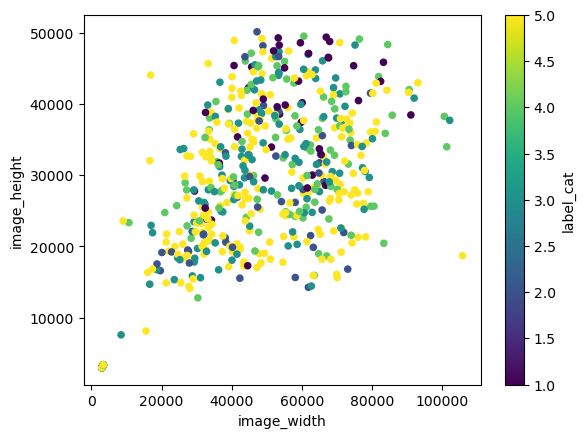

In [9]:
train_df.plot.scatter(x='image_width', y='image_height', c='label_cat', colormap='viridis')
plt.show()

Tile estimate

In [18]:
def tile_count(width, height, tile_size=256):
    return int((width/tile_size)) * int((height/tile_size))

tile_counts = train_df.apply(lambda row: tile_count(row.image_width, row.image_height), axis=1)

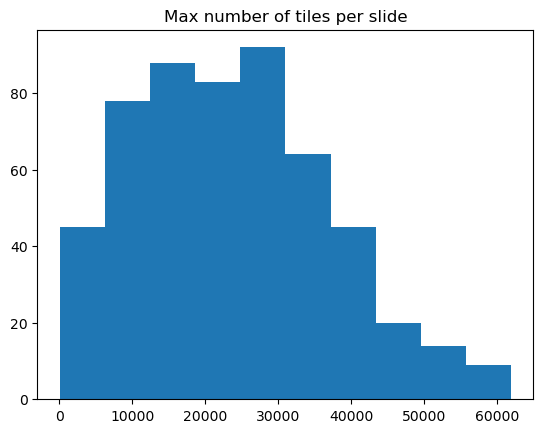

In [17]:
plt.hist(tile_counts)
plt.title('Max number of tiles per slide')
plt.show()

In [19]:
train_df

,image_id,label,image_width,image_height,is_tma,label_cat
0,4,HGSC,23785,20008,False,5
1,66,LGSC,48871,48195,False,2
2,91,HGSC,3388,3388,True,5
3,281,LGSC,42309,15545,False,2
4,286,EC,37204,30020,False,3
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,2
534,65094,MC,55042,45080,False,1
535,65300,HGSC,75860,27503,False,5
536,65371,HGSC,42551,41800,False,5


One hot encoding for is_tma

In [25]:
train_df['is_tma'].value_counts()

False    513
True      25
Name: is_tma, dtype: int64

In [26]:
is_tma_categories = {False: 0, True: 1}

train_df['is_tma_hot'] = train_df['is_tma'].map(is_tma_categories)

train_df['is_tma_hot'].value_counts()

0    513
1     25
Name: is_tma_hot, dtype: int64

#### Most images in hidden test set are TMA, whereas most in training set are not

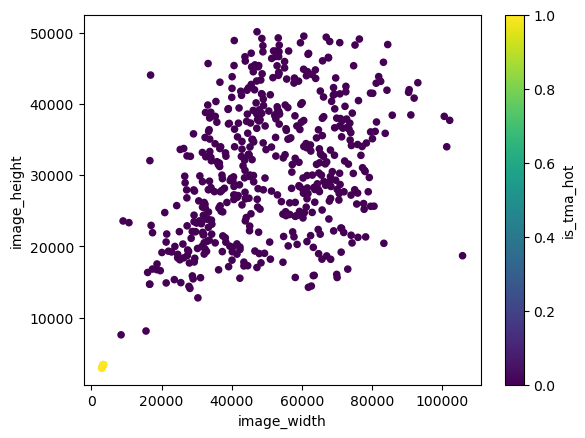

In [27]:
train_df.plot.scatter(x='image_width', y='image_height', c='is_tma_hot', colormap='viridis')
plt.show()

TMA images are much smaller than other WSIs

In [28]:
train_df[train_df['is_tma']==True]

,image_id,label,image_width,image_height,is_tma,label_cat,is_tma_hot
2,91,HGSC,3388,3388,True,5,1
37,4134,MC,2964,2964,True,1,1
76,8280,HGSC,2964,2964,True,5,1
83,9200,MC,3388,3388,True,1,1
112,13568,LGSC,2964,2964,True,2,1
149,17637,HGSC,2964,2964,True,5,1
176,21020,MC,3388,3388,True,1,1
236,29084,LGSC,3388,3388,True,2,1
263,31594,EC,3388,3388,True,3,1
288,35565,MC,2964,2964,True,1,1


In [29]:
train_df[train_df['is_tma']==True]['label'].value_counts()

HGSC    5
MC      5
LGSC    5
EC      5
CC      5
Name: label, dtype: int64

Save new labels to new csv

In [35]:
train_df.to_csv(os.path.join(DATA_DIR, 'train_hot.csv'))

### Explore validation data

In [30]:
val_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
val_df

,image_id,image_width,image_height
0,41,28469,16987


Only one validation image!

Check image exists

In [31]:
for image_id in val_df['image_id']:
    assert os.path.exists(os.path.join(DATA_DIR, 'test_images', f'{image_id}.png')), \
    f'No image found for ID {image_id}'

In [32]:
print(f'{len(os.listdir(os.path.join(DATA_DIR, "test_images")))} test images')
print(f'{len(os.listdir(os.path.join(DATA_DIR, "test_thumbnails")))} thumbnails of training images')

1 test images
1 thumbnails of training images


### Check sample submission

In [33]:
sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_submission_df

,image_id,label
0,41,HGSC
